In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Mini Batch Training
> Basic training loop, Parameters, and Optim

We're going to start training!

In [2]:
#export
from exp.nb_02 import *

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

## Data

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
x_train.shape

torch.Size([50000, 784])

In [5]:
n, m = x_train.shape

In [6]:
c = y_train.max()+1;c 

tensor(10)

## Basic Model and Preds

In [7]:
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [9]:
model = Model(m, nh, 10)

In [10]:
pred = model(x_train)

## Loss Function: Cross Entropy Loss

Each grayscale image of a handwritten shape in our dataset has exactly 1 correct answer - an integer between 0 and 9 - these are called the labels or targets. 

Our `y_train` is a tensor of integers that map to the `x_train` images. 

We can index into the `y_train` to see the labels to images 0, 1, and 2. 

In [11]:
y_train[:3]

tensor([5, 0, 4])

We could also think of these labels as one-hot encoded vectors of length 10 where the label corresponds to a 1 at the label's index and everything else is a zero.

In [12]:
y0 = torch.zeros(10)
y0[y_train[0]] = 1
y0

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

The model's output is simply a length 10 vector for every example that is the result of numerous matrix multiplications:

In [13]:
pred[0]

tensor([ 0.0918,  0.0414,  0.1069, -0.1664,  0.0340,  0.1779,  0.0468, -0.0298,
        -0.0210, -0.1646], grad_fn=<SelectBackward>)

### Softmax

What we would like is a probability distribution over each of our 10 classes: each class gets a probabilty, the highest corresponds to the class the model has learned is the most "correct". The model most therefore learn and adjust its parameters by quantifying how wrong its guess was.

In order to accomplish this for our multi-class problem we'll use cross entropy loss.

The first step is to scale the outputs by putting them through a softmax function:
<p>
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 
</p>

This turns our length 10 output vector into a probability distribution.

For example, for the numerator, to raise the first two rows to the e is just:

In [14]:
pred[:2].exp()

tensor([[1.0962, 1.0423, 1.1129, 0.8467, 1.0346, 1.1947, 1.0479, 0.9706, 0.9792,
         0.8483],
        [1.0869, 1.0400, 1.1389, 0.9027, 1.0509, 1.3027, 1.1103, 1.0629, 1.0749,
         0.8000]], grad_fn=<ExpBackward>)

The denominator is trickier because we don't want to sum all of the rows together. We need divide each exponentiated value by its own row. 

Therefore, this won't work because it lumps everything together:

In [15]:
pred[:2].exp().sum()

tensor(20.7437, grad_fn=<SumBackward0>)

Instead we need to pass `keepdim=True`

In [16]:
pred[:2].exp().sum(-1, keepdim=True)

tensor([[10.1734],
        [10.5703]], grad_fn=<SumBackward1>)

Finally, here are the first two rows softmaxed:

In [17]:
soft_preds = pred[:2].exp() / pred[0].exp().sum(-1, keepdim=True); soft_preds

tensor([[0.1077, 0.1025, 0.1094, 0.0832, 0.1017, 0.1174, 0.1030, 0.0954, 0.0963,
         0.0834],
        [0.1068, 0.1022, 0.1119, 0.0887, 0.1033, 0.1281, 0.1091, 0.1045, 0.1057,
         0.0786]], grad_fn=<DivBackward0>)

And if we sum a row we get 1:

In [18]:
soft_preds[0].sum()

tensor(1., grad_fn=<SumBackward0>)

Here is our function:

In [19]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [20]:
soft_preds1 = log_softmax(pred)

We can immediately refactor this by remembering that:

<p>
$$ \log{\frac{a}{b}} = \log{a} - \log{b} $$
    
</p>

Therefore:

<p>
$$ \displaystyle \log{\frac{e^x_i}{\sum_{j=0}^{n-1} e^x_j}} = \log{e^x} - \log{\sum_{j=0}^{n-1} e^x_j} = x  - \log{\sum_{j=0}^{n-1} e^x_j} $$
</p>

In code this is:

In [21]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [22]:
soft_preds = log_softmax(pred)

In [23]:
test_near(soft_preds, soft_preds1)

Now that we have an output vector of predictions, $\hat{y}$, in the form of a probability distribution over the possible classes of $y$ (0-9) we can use cross entropy loss to caculate just how far off our prediction is from the target value.

We're trying to find how dissimilar our prediction is to the target. So we are comparing the two distributions. 

Assuming our $y$ is one-hot encoded, we calculate the cross entropy loss for a single example by taking the dot product of the two vectors:

<p>
$$  L =  -y \cdot \log{\hat{y}} $$
</p>

In [24]:
-(y0 @ soft_preds[0])

tensor(2.1419, grad_fn=<NegBackward>)

But we can do this another way without having to one-hot encode our labels. 

We'll use integer array indexing - we can pass a list of integers for each dimension and get back those specific rows/columns.

In [25]:
-soft_preds[[0],[y_train[0]]]

tensor([2.1419], grad_fn=<NegBackward>)

Now we turn that into a proper loss function which takes averages all of the negative loss logs over the entire output.

In [26]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [27]:
loss = nll(soft_preds, y_train); loss

tensor(2.3071, grad_fn=<NegBackward>)

#### LogSumExp Trick

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

<p>
$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$
</p>
    
    
where a is the maximum of the $x_{j}$.

In [28]:
def logsumexp(x):
    m = x.max(-1)[0] # grab the largest number in x
    print(m)
    return m + (x-m[:,None]).exp().sum(-1).log() # subtract it out and then add it back in the end

### Pytorch F.cross_entropy

We've now built our loss function so let's go ahead and use the Pytorch version which combines `log_softmax` and `nll_loss` in a single function.

In [29]:
pyloss = F.cross_entropy(pred, y_train); pyloss

tensor(2.3070, grad_fn=<NllLossBackward>)

In [30]:
test_near(pyloss, loss)

It works!

## Basic Training Loop

We have all the parts now to create an algorithm!

The training loop is combines everything we have done so far into an interative process. We loop over the data again and again to fine-tune our model's parameters. 

Here is what we need the training loop to do:

- Get a batch of inputs and pass them to the model to get a batch of outputs
- Compute the loss of by comparing the outputs to the labels
- Calculate the gradients of the loss function with respect to the model parameters
- Finally update the parameters using those gradients and a learning rate

### Single Batch

In [31]:
loss_func = F.cross_entropy

It would be nice if we had some sort of metric to follow to see how many of the training examples we are getting correct. 

We'll start with accuracy.

In [32]:
torch.argmax(pred, dim=1)[:4]

tensor([5, 5, 5, 6])

In [33]:
#export
def accuracy(yh, y): return (torch.argmax(yh, dim=1)==y).float().mean()

Let's create a single mini-batch to test that it works:

In [34]:
bs=128                  # batch size
xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions

This will give us 128 predictions - each prediction here being a vector of length 10.

In [35]:
preds[0], preds.shape

(tensor([ 0.0918,  0.0414,  0.1069, -0.1664,  0.0340,  0.1779,  0.0468, -0.0298,
         -0.0210, -0.1646], grad_fn=<SelectBackward>),
 torch.Size([128, 10]))

Now we can put these predictions through our loss function with our labels and get some sort of measurement as to how far off they are:

In [36]:
yb = y_train[0:bs]
loss = loss_func(preds, yb); loss

tensor(2.3045, grad_fn=<NllLossBackward>)

In [37]:
accuracy(preds, yb)

tensor(0.0469)

About 10% accuracy, that's basically choosing randomly.

We have a long way to go but at least everything appears to be working.

Now let's look at our model's weights:

In [38]:
model.layers[0].weight

Parameter containing:
tensor([[ 0.0302,  0.0338, -0.0123,  ..., -0.0202,  0.0214,  0.0049],
        [-0.0146, -0.0077,  0.0349,  ...,  0.0049,  0.0070,  0.0019],
        [ 0.0141,  0.0241, -0.0318,  ..., -0.0278,  0.0213, -0.0353],
        ...,
        [-0.0132, -0.0237, -0.0061,  ...,  0.0226, -0.0165, -0.0246],
        [ 0.0126, -0.0019,  0.0001,  ...,  0.0199,  0.0091, -0.0242],
        [ 0.0325, -0.0055, -0.0159,  ...,  0.0244,  0.0131,  0.0208]],
       requires_grad=True)

In [39]:
model.layers[0].weight.grad

At this stage the gradients with respect to the loss have not been computed. 

Pytorch only computes them once `.backward` is called. Let's do that:

In [40]:
loss.backward()

In [41]:
model.layers[0].weight.grad[0][:100]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6134e-05,
        3.1168e-05, 2.7501e-05, 1.4667e-

### Training Loop

Let's finally begin to train. 

Three hyperparameters we need to set are the batch size, the learning rate and the number of epochs (the number of times we iterate through the entire dataset)

In [42]:
bs = 64
lr = 0.5
epochs = 1

In [43]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        xb = x_train[i:i+bs]
        yb = y_train[i:i+bs]
        loss = loss_func(model(xb), yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= lr * l.weight.grad
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [44]:
loss_func(model(xb), yb)

tensor(0.1821, grad_fn=<NllLossBackward>)

And it's >90% accuracy. Not terrible for a simple neural net. 

In [45]:
accuracy(model(x_train[:512]), y_train[:512])

tensor(0.9316)

## Parameters

### Parameters

We'll start by no longer treating our Relu as a separate layer. Instead we'll use `F.relu` which is the functional form that returns activations. 

We then have two linear layers from `nn` these linear layers are automatically registered by the `nn.Module` class as the parameters of the model. 

We can call `model.parameters()` now and it will return a generator that does essentially what we were doing manually by iterating through the list of layers and checking for the `weight` attribute.

In [46]:
nh = 64

In [47]:
class Model(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def forward(self, x):
        return self.l2(F.relu(self.l1(x)))

In [48]:
n,m

(50000, 784)

In [49]:
model = Model(m, 10)

Let's take a look inside our model.

We can do this by calling the `.named_children` method on the model.


    Returns an iterator over immediate children modules, yielding both the name of the module as well as the module itself.

In [50]:
for l in model.named_children(): print(f"{l[0]} : {l[1]}")

l1 : Linear(in_features=784, out_features=64, bias=True)
l2 : Linear(in_features=64, out_features=10, bias=True)


Pytorch's `nn.Module` has `__repr__` defined as the following:

```python
def __repr__(self):
        # We treat the extra repr like the sub-module, one item per line
        extra_lines = []
        extra_repr = self.extra_repr()
        # empty string will be split into list ['']
        if extra_repr:
            extra_lines = extra_repr.split('\n')
        child_lines = []
        for key, module in self._modules.items():
            mod_str = repr(module)
            mod_str = _addindent(mod_str, 2)
            child_lines.append('(' + key + '): ' + mod_str)
        lines = extra_lines + child_lines

        main_str = self._get_name() + '('
        if lines:
            # simple one-liner info, which most builtin Modules will use
            if len(extra_lines) == 1 and not child_lines:
                main_str += extra_lines[0]
            else:
                main_str += '\n  ' + '\n  '.join(lines) + '\n'

        main_str += ')'
        return main_str`
```

In [51]:
model

Model(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=10, bias=True)
)

### Fit

Let's create a function that we can call which will run our training loop. 

This is standard for Machine Learning libraries like Sklearn.

In [52]:
def fit():
    print("Training...")
    for epoch in range(epochs):
        for i in range(0,n,bs):
            end = i+bs if i+bs < n else n
            xb = x_train[i:end]
            yb = y_train[i:end]
            preds = model(xb)
            loss = loss_func(preds, yb)
            
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    model.zero_grad()

In [53]:
fit()

Training...


In [54]:
loss_func(model(xb),yb)

tensor(0.3917, grad_fn=<NllLossBackward>)

In [55]:
accuracy(model(x_valid), y_valid)

tensor(0.9116)

Question: How does Pytorch know what attributes in `__init__` to set as the model parameters?

In Python every time an attribute is assigned during a class initialization, `__setattr__()` is called. 

When we inherit from `nn.Module` and then execute `super().__init__()` Pytorch creates the following 'private' attributes: 
```python
        self.training = True
        self._parameters = OrderedDict()
        self._buffers = OrderedDict()
        self._backward_hooks = OrderedDict()
        self._forward_hooks = OrderedDict()
        self._forward_pre_hooks = OrderedDict()
        self._state_dict_hooks = OrderedDict()
        self._load_state_dict_pre_hooks = OrderedDict()
        self._modules = OrderedDict()
```

When the model is instantiated from the `Model` class and `self.l1 = nn.Linear` is set as in attribute `__setattr__()` is called. 

Pytorch then does the following:

- checks if the attribute is a Parameter or a Module
- checks to make sure that `nn.Module` `__init__` was called
- then registers the Parameter or (sub)Module

```Python

class Parameter

    '''A kind of Tensor that is to be considered a module parameter.
    
    Parameters are ~torch.Tensor subclasses, that have a very special property when used with Module s - when they're assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in ~Module.parameters iterator. Assigning a Tensor doesn't have such effect. This is because one might want to cache some temporary state, like last hidden state of the RNN, in the model. If there was no such class as Parameter, these temporaries would get registered too.

Arguments: data (Tensor): parameter tensor. requires_grad (bool, optional): if the parameter requires gradient. See excluding-subgraphs for more details. Default: True'''
```

```python
class Module
    
    '''Base class for all neural network modules.

    Your models should also subclass this class.
    
    Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:'''
```

We can demonstrate this by building a dummy module that has a dictionary called `_modules`

In [56]:
class DummyModule():
    def __init__(self, n_in, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k,v):
        if not k.startswith("_"): # register any keys that do not start with '_'
            self._modules[k] = v # put it inside modules dict
        super().__setattr__(k,v)
    
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [57]:
mdl = DummyModule(m, 10)

In [58]:
mdl

{'l1': Linear(in_features=784, out_features=64, bias=True), 'l2': Linear(in_features=64, out_features=10, bias=True)}

In [59]:
[o.shape for o in mdl.parameters()]

[torch.Size([64, 784]),
 torch.Size([64]),
 torch.Size([10, 64]),
 torch.Size([10])]

### Registering Modules

Now let's say we wanted to use the layers approach that we wrote earlier. 

In [60]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10)]

In [61]:
class Model(nn.Module):
        def __init__(self, layers):
            super().__init__() # sets up the parameters module dict and other dicts
            self.layers = layers
            for i,l in enumerate(self.layers):
                self.add_module(f'l{i}',l)
            
        def forward(self, x):
            for l in self.layers: x = l(x)
            return x

In [62]:
model = Model(layers)

In [63]:
model

Model(
  (l0): Linear(in_features=784, out_features=64, bias=True)
  (l1): ReLU()
  (l2): Linear(in_features=64, out_features=10, bias=True)
)

### nn.ModuleList

If we insist on using the layers technique we can use the built in Pytorch `nn.ModuleList`

In [64]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__() 
        self.layers = nn.ModuleList(layers)
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [65]:
model = Model(layers)

In [66]:
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [67]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

Training...


(tensor(0.4165, grad_fn=<NllLossBackward>), tensor(0.8750))

### nn.Sequential

Even easier would be to use the Pytorch `nn.Sequential`

In [68]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10))

In [69]:
model

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [70]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

Training...


(tensor(0.3879, grad_fn=<NllLossBackward>), tensor(0.8750))

## Optim

### Optimizer Step

Let's refactor our optimization step. 

In our training loop we called backward on the loss to compute the gradients and then to make the actual updates to the weights we did the following:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

We can simplify this bit of the loop if we instead put this away into an `Optimizer` class which will then have two separate methods: 

```python
opt.step()
opt.zero_grad()
```

In [71]:
class Optimizer():
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
    
    def step(self):        
        with torch.no_grad():
            for p in self.model.parameters():
                p -= p.grad * self.lr
        
    def zero(self):
        self.model.zero_grad()

In [72]:
opt = Optimizer(model, lr)

In [73]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        end = i+bs if i+bs < n else n
        xb = x_train[i:end]
        yb = y_train[i:end]
        loss = loss_func(model(xb), yb)
        loss.backward()
        opt.step()
        opt.zero()

In [74]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.2990, grad_fn=<NllLossBackward>), tensor(0.9375))

### Pytorch Optim

Now let's see the Pytorch version.

`optim.SGD.step` iterates through each `param_group` and then again through each group's `params` key which contain the layers in that group

In [75]:
opt = optim.SGD(model.parameters(), lr=lr)

In [76]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.0242, -0.0223,  0.0028,  ..., -0.0136, -0.0251,  0.0132],
           [ 0.0249,  0.0300,  0.0280,  ..., -0.0090,  0.0227, -0.0340],
           [ 0.0076,  0.0300,  0.0173,  ...,  0.0251, -0.0326, -0.0252],
           ...,
           [-0.0334,  0.0330, -0.0164,  ...,  0.0063,  0.0304,  0.0350],
           [-0.0112,  0.0052, -0.0064,  ..., -0.0089,  0.0333,  0.0117],
           [ 0.0170,  0.0224, -0.0226,  ...,  0.0107,  0.0014,  0.0281]],
          requires_grad=True),
   Parameter containing:
   tensor([ 0.0695, -0.1221, -0.2036,  0.0419, -0.4452, -0.0561, -0.0798, -0.1187,
           -0.3741,  0.0679, -0.1101, -0.1773, -0.3565, -0.2370, -0.0692, -0.1396,
           -0.2085, -0.3121, -0.2558, -0.4352, -0.1824, -0.6495, -0.0619, -0.0654,
           -0.5264, -0.1799, -0.5893, -0.1687, -0.0630, -0.0676, -0.0492, -0.2636,
           -0.1226, -0.1610, -0.3492,  0.1063, -0.2487,  0.0685, -0.0983, -0.2556,
           -0.0129, -0.2272, -0.1577, -

Let's make a quick function to get model and an optimizer:

In [77]:
#export
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [78]:
model, opt = get_model()

In [79]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        end = i+bs if i+bs < n else n
        xb=x_train[i:end]
        yb=y_train[i:end]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [80]:
vpreds = model(x_valid)
loss,acc = loss_func(vpreds, y_valid), accuracy(vpreds, y_valid)
loss,acc

(tensor(0.1690, grad_fn=<NllLossBackward>), tensor(0.9511))

## Dataset and DataLoader

### Dataset

Another part of our training loop we can improve is:

```python
    for i in range(0,n,bs):
        end = i+bs if i+bs < n else n
        xb=x_train[i:end]
        yb=y_train[i:end]
```

Let's build a `Dataset` class that will hold the `x`'s and `y`'s in one object. 

```python
xb, yb = train_ds[i:end]
```

In [81]:
#export
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x,y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,key): 
        return self.x[key], self.y[key]

In [82]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [83]:
assert len(train_ds) == len(x_train)

In [84]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [85]:
model, opt = get_model()

In [86]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        end = i+bs if i+bs < n else n
        xb, yb = train_ds[i:end]
        loss = loss_func(model(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [87]:
vpreds = model(x_valid)
loss,acc = loss_func(vpreds, y_valid), accuracy(vpreds, y_valid)
loss,acc

(tensor(0.2110, grad_fn=<NllLossBackward>), tensor(0.9360))

### DataLoader from Scratch

And we can use the same refactoring logic to make it so we can simply pull `x` and `y` batches out of a `DataLoader` class that holds the `Dataset` class we just made. 

```python
for xb, yb in train_dl:
    preds = model(xb)
    loss = loss_func(preds, yb)
```

In [88]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs

    def __len__(self): 
        return len(self.ds/self.bs)
    
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): 
            yield self.ds[i:i+self.bs]

In [89]:
train_dl = DataLoader(train_ds, 64)
valid_dl = DataLoader(valid_ds, 128)

In [90]:
xb, yb = next(iter(valid_dl))

In [91]:
assert xb.shape == (128, 28*28)

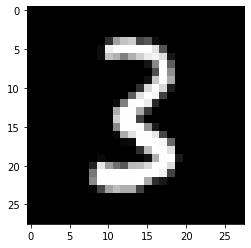

In [92]:
plt.imshow(xb[0].view(28, 28))

In [93]:
yb[0]

tensor(3)

In [94]:
model, opt = get_model()

In [95]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [96]:
fit()

In [97]:
vpreds = model(x_valid)
loss,acc = loss_func(vpreds, y_valid), accuracy(vpreds, y_valid)
loss,acc

(tensor(0.1685, grad_fn=<NllLossBackward>), tensor(0.9529))

### Random Sampling v1

For certain datasets where the dependent variable is in a specific order we would want to shuffle the data before loading it into batches and putting it through the model. 

Every epoch we'll iterate through the entire dataset randomly. The model will get to see each training example once but the order will be different each time. 

To do this we need our `Dataloader` to send a batch size of random integers that are within the range of the dataset. 

We'll need permutations:

In [98]:
torch.randperm(10)

tensor([3, 7, 0, 4, 5, 2, 6, 1, 8, 9])

In [99]:
class DataLoader():
    def __init__(self, ds, bs, shuffle=False):
        self.ds = ds
        self.bs = bs
        self.shuffle = shuffle
    
    def __iter__(self):
        if self.shuffle:
            perms = torch.randperm(len(self.ds))
            for i in range(0, len(perms), bs): yield self.ds[perms[i:self.bs]]
        else:
            for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [100]:
test_dl = DataLoader(train_ds, 128, shuffle=True)
test_valid_dl = DataLoader(valid_ds, 128, shuffle=False)

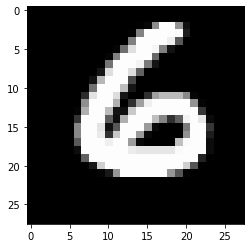

In [101]:
xb, yb = next(iter(test_dl))
plt.imshow(xb[0].view(28,28))

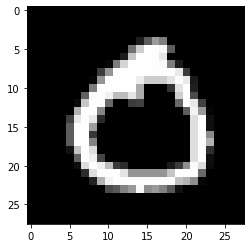

In [102]:
xb, yb = next(iter(test_dl))
plt.imshow(xb[0].view(28,28))

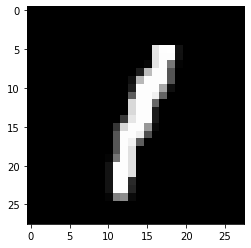

In [103]:
xb, yb = next(iter(test_dl))
plt.imshow(xb[0].view(28,28))

In [104]:
model, opt = get_model()
fit()

In [105]:
vpreds = model(x_valid)
loss,acc = loss_func(vpreds, y_valid), accuracy(vpreds, y_valid)
loss,acc

(tensor(0.1671, grad_fn=<NllLossBackward>), tensor(0.9487))

### Random Sampler v2

In [106]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n = len(ds) # just the length of the dataset not the whole dataset
        self.bs = bs
        self.shuffle = shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [107]:
small_ds = Dataset(*train_ds[:10])

To test this out let's see when `shuffle=False`

In [108]:
s = Sampler(small_ds, 3, False)
[x for x in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [109]:
s = Sampler(small_ds, 3, True)
[x for x in s]

[tensor([7, 1, 4]), tensor([9, 2, 0]), tensor([8, 5, 6]), tensor([3])]

In [110]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds = ds
        self.sampler = sampler
        self.collate_fn = collate_fn
    
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [111]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [112]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

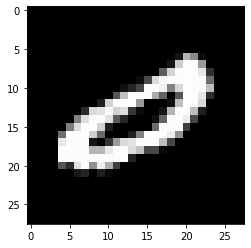

In [113]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))

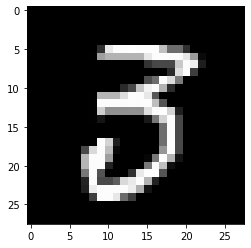

In [114]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))

### Pytorch DataLoader

Now we'll use the Pytorch version. 

It has a couple of particularly interesting args:

- `drop_last` : drop the last incomplete batch 
-  `num_workers`: how many subprocesses to use for data loading. ``0`` means that the data will be loaded in the main process.

In [116]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

train_dl = DataLoader(train_ds, bs, shuffle=True)
valid_dl = DataLoader(valid_ds, 128, shuffle=False)

In [117]:
model, opt = get_model()
fit()

In [118]:
vpreds = model(x_valid)
loss,acc = loss_func(vpreds, y_valid), accuracy(vpreds, y_valid)
loss,acc

(tensor(0.4490, grad_fn=<NllLossBackward>), tensor(0.8611))

## Validation

A validation set is a key component to training properly: it is the only real indication we have that the model learning something useful. 

Specifically, it signals to us whether or not the model is overfitting to the training data. 

If we were to simply watch the training accuracy we would mostly likely see a continual improvement, as the loss diminishes and the accuracy increases to nearly 100%. 

That only indicates the performance of the model on labelled data. If the model's learning algorithm is powerful and it has enough parameters it can memorize the training data. 

But then, during inference time, when it is used to make predictions on unseen data, i.e. generalize, it may do horribly. 

So let's build a more complete training loop that includes a validation error:

(Note: `model.train()` and `model.eval()` are used to turn on and off certain types of layers like Dropout and BatchNorm.)

In [119]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        model.train()
        
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            

        model.eval()
        vloss=[]
        acc=[]
        with torch.no_grad():
            for xb,yb in valid_dl:
                preds = model(xb)
                vloss.append(loss_func(preds, yb))
                acc.append(accuracy(preds, yb))
        print('loss:', sum([i.item() for i in vloss])/len(valid_dl))
        print('accuracy:', sum([i.item() for i in acc])/len(valid_dl))

In [120]:
model, opt = get_model()
fit(2, model, loss_func, opt, train_dl, valid_dl)

loss: 0.1706093008146633
accuracy: 0.9481803797468354
loss: 0.19026051393321045
accuracy: 0.9396756329113924


In [121]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Creating our dataloaders, getting a model and optimizer, and training can be run in three lines of code:

In [122]:
get_dls(train_ds, valid_ds, 128)
model, opt = get_model()
fit(4, model, loss_func, opt, train_dl, valid_dl)

loss: 0.21858973362589185
accuracy: 0.9353243670886076
loss: 0.11040582522584856
accuracy: 0.9675632911392406
loss: 0.11853115729798999
accuracy: 0.9622231012658228
loss: 0.1047832053537846
accuracy: 0.9698378164556962


In [123]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp\nb_03.py
